<a href="https://colab.research.google.com/github/Aakushah/cifar10-cnn-pytorch/blob/main/cifar10_image_classifier_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


## About the CIFAR-10 Dataset

The **CIFAR-10** dataset is a widely used benchmark in machine learning and computer vision. It consists of **60,000** color images in **10 classes**, with **6,000 images per class**.

- **Image size:** 32x32 pixels  
- **Channels:** 3 (Red, Green, Blue)  
- **Training set:** 50,000 images  
- **Test set:** 10,000 images  

### Classes
The dataset includes the following classes:

`airplane`, `automobile`, `bird`, `cat`, `deer`, `dog`, `frog`, `horse`, `ship`, `truck`

Each image belongs to exactly one class.

### Why use CIFAR-10?

- It is simple enough for beginners but challenging enough to showcase deep learning techniques.
- The dataset is well-supported by libraries like `torchvision`, allowing easy data loading and preprocessing.
- It provides a good foundation to practice designing and training convolutional neural networks (CNNs).
- Results on CIFAR-10 are widely referenced, so it is easy to compare your model’s performance with existing work.

---

You can learn more about CIFAR-10 on the [official website](https://www.cs.toronto.edu/~kriz/cifar.html).




##  Training a Classifier

### Load and normalize CIFAR10




In [63]:
import torch
import torchvision
import torchvision.transforms as transforms

In [64]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### show some of the training images

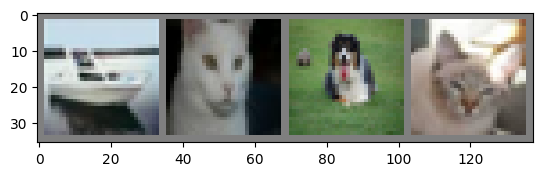

ship  cat   dog   cat  


In [65]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Define a Convolutional Neural Network

In [66]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### Define a Loss function and optimizer

In [67]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Train the network

In [68]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.206
[1,  4000] loss: 1.843
[1,  6000] loss: 1.689
[1,  8000] loss: 1.588
[1, 10000] loss: 1.526
[1, 12000] loss: 1.482
[2,  2000] loss: 1.392
[2,  4000] loss: 1.369
[2,  6000] loss: 1.348
[2,  8000] loss: 1.323
[2, 10000] loss: 1.296
[2, 12000] loss: 1.293
Finished Training


### save trained model

In [69]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### Test the network on the test data

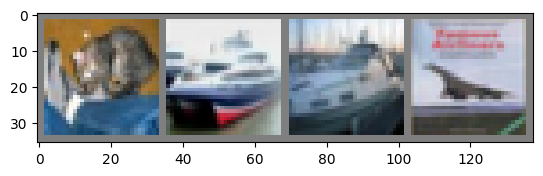

GroundTruth:  cat   ship  ship  plane


In [70]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [71]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [72]:
outputs = net(images)

In [73]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  ship 


` results seem pretty good. `

### Check network performs on the whole dataset

In [74]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 54 %


 ### Check  what are the classes that performed well, and the classes that did not perform well

In [75]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 62.8 %
Accuracy for class: car   is 75.3 %
Accuracy for class: bird  is 25.3 %
Accuracy for class: cat   is 43.9 %
Accuracy for class: deer  is 31.3 %
Accuracy for class: dog   is 64.0 %
Accuracy for class: frog  is 71.0 %
Accuracy for class: horse is 51.2 %
Accuracy for class: ship  is 64.0 %
Accuracy for class: truck is 57.8 %
